In [2]:
import numpy as np
np.random.seed(42)
import pandas as pd
import torch
import torch.nn as nn
import plotly.express as px
import plotly.graph_objs as go
from rich.table import Table
from collections import namedtuple

# Generating a random walk time series

<Axes: xlabel='date'>

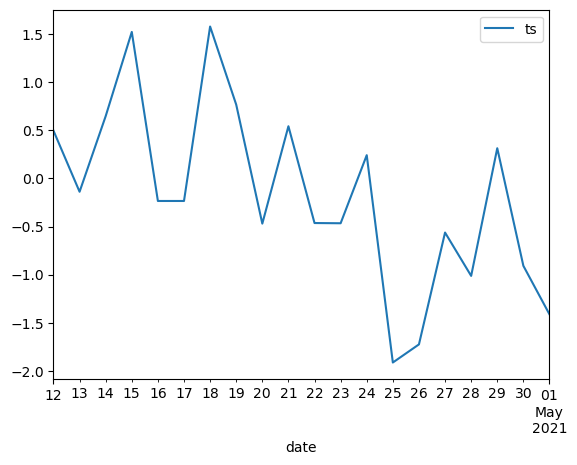

In [3]:
N = 20
df = pd.DataFrame({
    "date": pd.date_range(periods=N, start="2021-04-12", freq="D"),
    "ts": np.random.randn(N)
})
df.plot(x="date", y="ts")

## Creating windows to simulate batch training

In [4]:
ts = torch.from_numpy(df.ts.values).float()
ts

tensor([ 0.4967, -0.1383,  0.6477,  1.5230, -0.2342, -0.2341,  1.5792,  0.7674,
        -0.4695,  0.5426, -0.4634, -0.4657,  0.2420, -1.9133, -1.7249, -0.5623,
        -1.0128,  0.3142, -0.9080, -1.4123])

In [5]:
window = 15
# Creating windows of 15 over the dataset
ts_dataset = ts.unfold(0, size=window, step=1)
ts_dataset[:2], ts_dataset.shape

(tensor([[ 0.4967, -0.1383,  0.6477,  1.5230, -0.2342, -0.2341,  1.5792,  0.7674,
          -0.4695,  0.5426, -0.4634, -0.4657,  0.2420, -1.9133, -1.7249],
         [-0.1383,  0.6477,  1.5230, -0.2342, -0.2341,  1.5792,  0.7674, -0.4695,
           0.5426, -0.4634, -0.4657,  0.2420, -1.9133, -1.7249, -0.5623]]),
 torch.Size([6, 15]))

In [6]:
bz, _ = ts_dataset.shape

# Feed Forward Network

In [7]:
# The FFN we define would have this architecture
# window(windowed input) >> 64 (hidden layer 1) >> 32 (hidden layer 2) >> 32 (hidden layer 2) >> 1 (output)
ffn = nn.Sequential(
    nn.Linear(in_features=window,out_features=64), # (batch-size x window) --> (batch-size x 64)
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=32), # (batch-size x 64) --> (batch-size x 32)
    nn.ReLU(),
    nn.Linear(in_features=32,out_features=32), # (batch-size x 32) --> (batch-size x 32)
    nn.ReLU(),
    nn.Linear(in_features=32,out_features=1), # (batch-size x 32) --> (batch-size x 1)
)

In [8]:
print("Input Shape:", ts_dataset.shape)
# We use this sequential block like this:
ffn(ts_dataset)
# or more explicitly
ffn.forward(ts_dataset)

Input Shape: torch.Size([6, 15])


tensor([[-0.0153],
        [-0.0204],
        [-0.0505],
        [-0.0372],
        [ 0.0124],
        [-0.0220]], grad_fn=<AddmmBackward0>)

In [9]:
# Let's see how the data transforms through the network
table = Table(title="Feed Forward Network", show_lines=True)
table.add_column("Layer", justify="center", style="cyan", no_wrap=False)
table.add_column("Shape", style="magenta")

x = ts_dataset
table.add_row("Input", str(x.shape))
for m in ffn: # We can iterate through a sequential object like any python iterator
    x = m(x)
    table.add_row(str(m), str(x.shape))
table

                            Feed Forward Network                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃                       Layer                        ┃ Shape               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│                       Input                        │ torch.Size([6, 15]) │
├────────────────────────────────────────────────────┼─────────────────────┤
│ Linear(in_features=15, out_features=64, bias=True) │ torch.Size([6, 64]) │
├────────────────────────────────────────────────────┼─────────────────────┤
│                       ReLU()                       │ torch.Size([6, 64]) │
├────────────────────────────────────────────────────┼─────────────────────┤
│ Linear(in_features=64, out_features=32, bias=True) │ torch.Size([6, 32]) │
├────────────────────────────────────────────────────┼─────────────────────┤
│                       ReLU()                       │ torch.Size([6, 32]) │
├────────────────────────────────────────────────────┼─────────────────────┤
│ Linear(in_features=32, out_features=32, bias=True) │ torch.Size([6, 32]) │
├────────────────────────────────────────────────────┼─────────────────────┤
│                       ReLU()                       │ torch.Size([6, 32]) │
├────────────────────────────────────────────────────┼─────────────────────┤
│ Linear(in_features=32, out_features=1, bias=True)  │ torch.Size([6, 1])  │
└────────────────────────────────────────────────────┴─────────────────────┘

# Recurrent Neural Networks

## Vanilla RNN

In [10]:
#adding a dimension to the end because RNN expect input as a 3-d tensor
# using batch_first=True and therefore input dim is (batch, seq,feature)
rnn_input = ts_dataset.unsqueeze(-1)
rnn_input.shape

torch.Size([6, 15, 1])

In [11]:
rnn = nn.RNN(
    input_size=1,
    hidden_size=32,
    num_layers=1,
    batch_first=True,
    dropout=0,
    bidirectional=False,
)

output, hidden_states = rnn(rnn_input)

In [12]:
output.shape, hidden_states.shape

(torch.Size([6, 15, 32]), torch.Size([1, 6, 32]))

PyTorch RNNs include the hidden state as the output as well. The output is just the hidden states at each time step and the hidden state is the latest hidden states.
We can verify this by checking if the hidden state tensor is equal to the last output tensor

In [13]:
torch.equal(hidden_states[0], output[:,-1])

True

In [14]:
#Printing the first element of the batch for visual verification
(hidden_states[0,0], output[0,-1])

(tensor([-0.2991, -0.2603, -0.1266, -0.2008, -0.0787,  0.3756, -0.2015,  0.3130,
         -0.3046, -0.4812,  0.1133,  0.4745,  0.0533, -0.0199,  0.3130,  0.2411,
         -0.2256,  0.2062,  0.1918, -0.0985, -0.2319, -0.2146,  0.2262,  0.1472,
          0.0621,  0.2208, -0.2242,  0.1625,  0.0972, -0.1280, -0.5189, -0.2547],
        grad_fn=<SelectBackward0>),
 tensor([-0.2991, -0.2603, -0.1266, -0.2008, -0.0787,  0.3756, -0.2015,  0.3130,
         -0.3046, -0.4812,  0.1133,  0.4745,  0.0533, -0.0199,  0.3130,  0.2411,
         -0.2256,  0.2062,  0.1918, -0.0985, -0.2319, -0.2146,  0.2262,  0.1472,
          0.0621,  0.2208, -0.2242,  0.1625,  0.0972, -0.1280, -0.5189, -0.2547],
        grad_fn=<SelectBackward0>))

## Bi-Directional Stacked RNN

In [15]:
bi_stacked_rnn = nn.RNN(
    input_size=1,
    hidden_size=32,
    num_layers=5,
    batch_first=True,
    dropout=0,
    bidirectional=True,
)

output, hidden_states = bi_stacked_rnn(rnn_input)

In [16]:
output.shape, hidden_states.shape

(torch.Size([6, 15, 64]), torch.Size([10, 6, 32]))

## LSTM

In [ ]:
lstm = nn.LSTM(
    input_size=1,        # Number of features in each input time step
    hidden_size=32,      # Number of features in the hidden state
    num_layers=5,        # Number of stacked LSTM layers
    batch_first=True,    # Input and output tensors have shape (batch_size, seq_len, features)
    dropout=0,           # No dropout
    # bidirectional=True, # Uncomment for bidirectional LSTM (adds more complexity)
)

In [18]:
output.shape, hidden_states.shape, cell_states.shape

(torch.Size([6, 15, 32]), torch.Size([5, 6, 32]), torch.Size([5, 6, 32]))

In [19]:
torch.equal(hidden_states[-1], output[:,-1])

True

In [ ]:
output[0,-1] #selects the last time step's hidden state for the batch, 
#resulting in a tensor of shape (batch_size, hidden_size)

tensor([ 0.2003, -0.1237, -0.0519,  0.1079, -0.1223,  0.0964,  0.0644, -0.0824,
         0.0251, -0.0997, -0.0145,  0.0131, -0.0794, -0.0809, -0.0989,  0.0600,
         0.0706,  0.0607,  0.0440,  0.1178,  0.1262, -0.0963, -0.0410, -0.0199,
         0.0002, -0.0224, -0.1492, -0.0491, -0.0101,  0.0120, -0.0350, -0.0658],
       grad_fn=<SelectBackward0>)

In [ ]:
hidden_states[-1, 0,:]
#The LSTM architecture ensures that the hidden state of the last time step from the last layer (output[:, -1]) 
# is the same as the final hidden state stored in hidden_states[-1]

tensor([ 0.2003, -0.1237, -0.0519,  0.1079, -0.1223,  0.0964,  0.0644, -0.0824,
         0.0251, -0.0997, -0.0145,  0.0131, -0.0794, -0.0809, -0.0989,  0.0600,
         0.0706,  0.0607,  0.0440,  0.1178,  0.1262, -0.0963, -0.0410, -0.0199,
         0.0002, -0.0224, -0.1492, -0.0491, -0.0101,  0.0120, -0.0350, -0.0658],
       grad_fn=<SliceBackward0>)

## GRU

In [22]:
gru = nn.GRU(
    input_size=1,
    hidden_size=32,
    num_layers=5,
    batch_first=True,
    dropout=0,
    # bidirectional=True,
)

output, hidden_states = gru(rnn_input)

In [23]:
output.shape, hidden_states.shape

(torch.Size([6, 15, 32]), torch.Size([5, 6, 32]))

In [24]:
torch.equal(hidden_states[-1], output[:,-1])

True

In [25]:
output[0,-1]

tensor([-0.0708, -0.0187,  0.2816,  0.0787,  0.0136,  0.0636, -0.0668,  0.3498,
        -0.1823,  0.2359, -0.2111,  0.0820, -0.1423,  0.0401,  0.2038,  0.0695,
        -0.0484, -0.1178, -0.0783, -0.2401, -0.0408, -0.0214, -0.0875, -0.0986,
        -0.0585, -0.0701,  0.1570, -0.0324,  0.0694,  0.0452,  0.3440, -0.1715],
       grad_fn=<SelectBackward0>)

In [26]:
hidden_states[-1, 0,:]

tensor([-0.0708, -0.0187,  0.2816,  0.0787,  0.0136,  0.0636, -0.0668,  0.3498,
        -0.1823,  0.2359, -0.2111,  0.0820, -0.1423,  0.0401,  0.2038,  0.0695,
        -0.0484, -0.1178, -0.0783, -0.2401, -0.0408, -0.0214, -0.0875, -0.0986,
        -0.0585, -0.0701,  0.1570, -0.0324,  0.0694,  0.0452,  0.3440, -0.1715],
       grad_fn=<SliceBackward0>)

# Convolutional Neural Networks

In [27]:
#adding a dimension to the end because CNN expect input as a 3-d tensor
# input dim is (batch, channels (features), seq)
cnn_input = ts_dataset.unsqueeze(1)
cnn_input.shape

torch.Size([6, 1, 15])

In [28]:
k = 3
conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=k)
output = conv(cnn_input)

In [29]:
# Output should be in_dim - k + 1
assert output.size(-1)==cnn_input.size(-1)-k+1
output.shape

torch.Size([6, 1, 13])

## Effect of Stride and Dilation on Output

In [30]:
exp = namedtuple("Experiment", ["k","s","d"])

In [ ]:
exp_list= [
    exp(3,1,1),
    #Kernel Size (k): The size of the convolutional filter applied to the input.
# Stride (s): The step size by which the filter moves across the input.
# Dilation (d): The spacing between the filter elements. Higher dilation
# values allow the filter to cover a larger receptive field without increasing the kernel size.
    exp(5,1,1),
    exp(3,2,1),
    exp(3,1,2),
    exp(3,2,2),
    exp(5,2,2),
]

# Let's see output seq length for each setting of the CNN
table = Table(title="Convolutional Neural Network: Effect of Strides and Dilations on output", show_lines=True)
table.add_column("Kernel Size", justify="center", style="cyan", no_wrap=False)
table.add_column("Stride", style="magenta")
table.add_column("Dilation", style="purple3")
table.add_column("Input Seq Len", style="dark_orange")
table.add_column("Output Seq Len", style="deep_pink2")

x = ts_dataset

for ex in exp_list:
    conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=ex.k, stride=ex.s, dilation=ex.d)
    out = conv(cnn_input)
    table.add_row(str(ex.k), str(ex.s), str(ex.d), str(cnn_input.size(-1)), str(out.size(-1)))
table

  Convolutional Neural Network: Effect of Strides and Dilations on  
                               output                               
┏━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Kernel Size ┃ Stride ┃ Dilation ┃ Input Seq Len ┃ Output Seq Len ┃
┡━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│      3      │ 1      │ 1        │ 15            │ 13             │
├─────────────┼────────┼──────────┼───────────────┼────────────────┤
│      5      │ 1      │ 1        │ 15            │ 11             │
├─────────────┼────────┼──────────┼───────────────┼────────────────┤
│      3      │ 2      │ 1        │ 15            │ 7              │
├─────────────┼────────┼──────────┼───────────────┼────────────────┤
│      3      │ 1      │ 2        │ 15            │ 11             │
├─────────────┼────────┼──────────┼───────────────┼────────────────┤
│      3      │ 2      │ 2        │ 15            │ 6              │
├─────────────┼────────┼──────────┼───────────────┼────────────────┤
│      5      │ 2      │ 2        │ 15            │ 4              │
└─────────────┴────────┴──────────┴───────────────┴────────────────┘

In [ ]:
# Larger kernel sizes generally decrease the output sequence length because the filter spans more of the input.
# Higher strides significantly reduce the output sequence length by skipping positions during the convolution.
# Increased dilation increases the receptive field but minimally affects the output sequence length.

## Padding needed to keep dimensions the same

In [37]:
exp_list= [
    exp(3,1,1),
    exp(5,1,1),
    exp(3,2,1),
    exp(3,1,2),
    exp(3,2,2),
    exp(5,2,2),
]

# Let's see output seq length for each setting of the CNN
table = Table(title="Convolutional Neural Network: Padding to keep output same dimension", show_lines=True)
table.add_column("Kernel Size", justify="center", style="cyan", no_wrap=False)
table.add_column("Stride", style="magenta")
table.add_column("Dilation", style="purple3")
table.add_column("Input Seq Len", style="dark_orange")
table.add_column("Padding Required", style="deep_pink2")
table.add_column("Out", style="dark_sea_green4")

b, c, l = cnn_input.size()
for ex in exp_list:
    #Calculating the ideal padding
    padding = ex.d*(ex.k-1) + cnn_input.size(-1) * (ex.s-1) - (ex.s-1)
    #Pad the input on the left
    #using normal concatenation
    # padded_input = torch.concat([torch.zeros((b,c,padding)), cnn_input], dim=-1)
    # using inbuilt function. https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad
    # to pad the last dimension, we just need to give a tuple of left and right padding
    padded_input = torch.nn.functional.pad(cnn_input, pad=(padding,0))
    conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=ex.k, stride=ex.s, dilation=ex.d)
    out = conv(padded_input)
    assert out.size(-1) == cnn_input.size(-1)
    table.add_row(str(ex.k), str(ex.s), str(ex.d), str(cnn_input.size(-1)), str(padding), str(out.size(-1)))
table

    Convolutional Neural Network: Padding to keep output same dimension     
┏━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━┓
┃ Kernel Size ┃ Stride ┃ Dilation ┃ Input Seq Len ┃ Padding Required ┃ Out ┃
┡━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━┩
│      3      │ 1      │ 1        │ 15            │ 2                │ 15  │
├─────────────┼────────┼──────────┼───────────────┼──────────────────┼─────┤
│      5      │ 1      │ 1        │ 15            │ 4                │ 15  │
├─────────────┼────────┼──────────┼───────────────┼──────────────────┼─────┤
│      3      │ 2      │ 1        │ 15            │ 16               │ 15  │
├─────────────┼────────┼──────────┼───────────────┼──────────────────┼─────┤
│      3      │ 1      │ 2        │ 15            │ 4                │ 15  │
├─────────────┼────────┼──────────┼───────────────┼──────────────────┼─────┤
│      3      │ 2      │ 2        │ 15            │ 18               │ 15  │
├─────────────┼────────┼──────────┼───────────────┼──────────────────┼─────┤
│      5      │ 2      │ 2        │ 15            │ 22               │ 15  │
└─────────────┴────────┴──────────┴───────────────┴──────────────────┴─────┘

## Convolutions with equal weights is a rolling mean

In [38]:
conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, bias=False)

# This is the kernel weight
print(conv.weight.data.shape)

# assigning the kernel weights with uniform distribution
conv.weight.data = torch.tensor([1/3, 1/3, 1/3]).unsqueeze(0).unsqueeze(0)

torch.Size([1, 1, 3])


In [39]:
# Creating a tensor with the artificial time series
s = torch.from_numpy(df.ts.values.astype("float32"))

#Output of the convolutional layer
# unsqueezing to add dimensions. Conv1d expects a 3-d input
out = conv(s.unsqueeze(0).unsqueeze(0))
out

tensor([[[ 0.3354,  0.6775,  0.6455,  0.3516,  0.3703,  0.7042,  0.6257,
           0.2802, -0.1301, -0.1289, -0.2291, -0.7123, -1.1321, -1.4002,
          -1.1000, -0.4203, -0.5355, -0.6687]]],
       grad_fn=<ConvolutionBackward0>)

In [40]:
# Calculating the rolling mean over n-(k-1)
rolling_means = [s[i:i+3].mean() for i in range(len(s)-2)]
rolling_means

[tensor(0.3354),
 tensor(0.6775),
 tensor(0.6455),
 tensor(0.3516),
 tensor(0.3703),
 tensor(0.7042),
 tensor(0.6257),
 tensor(0.2802),
 tensor(-0.1301),
 tensor(-0.1289),
 tensor(-0.2291),
 tensor(-0.7123),
 tensor(-1.1321),
 tensor(-1.4002),
 tensor(-1.1000),
 tensor(-0.4203),
 tensor(-0.5355),
 tensor(-0.6687)]

In [41]:
#concatenating into a tensor
rolling_means = torch.cat([t.unsqueeze(0) for t in rolling_means])
# checking equality
torch.allclose(rolling_means, out)

True